# Inital split and data imputation 

## imports - packages

In [2]:
import numpy as np
import pandas as pd 
import geopandas as gpd
import seaborn as sns 
import matplotlib.pyplot as plt
import pyproj
import os 
import yaml

# Load configuration from a yaml file
config_path = '../configs/feature_value_dicts.yaml'
with open(config_path, 'r') as file:
    config = yaml.safe_load(file)

# set pyproj data directory to current env to ensure pyproj works properly
pyproj.datadir.set_data_dir("C:/Users/davha/anaconda3/envs/machine_learning_preprocessing/Library/share/proj")

## import datasets

In [3]:
# generated dataset from create_bwi_ml_dataset.py
data = pd.read_csv('../datasets/ml_bwi_v2.csv') 
data_cop = data.copy() # Use copy for the rest of the notebook

# federal states Germany 
regions = gpd.read_file('../datasets/de.json')

## preparation of supplementary datasets

In [4]:
# Adapt region naming in regions dataset 
county_dict = {
    "Schleswig-Holstein": 1,
    "Hamburg": 2,
    "Niedersachsen": 3,
    "Bremen": 4,
    "Nordrhein-Westfalen": 5,
    "Hessen": 6,
    "Rheinland-Pfalz": 7,
    "Baden-Württemberg": 8,
    "Bayern": 9,
    "Saarland": 10,
    "Berlin": 11,
    "Brandenburg": 12,
    "Mecklenburg-Vorpommern": 13,
    "Sachsen": 14,
    "Sachsen-Anhalt": 15,
    "Thüringen": 16
}

regions['name'] = regions['name'].replace(county_dict)


C:\Users\davha\AppData\Local\Temp\ipykernel_84788\854291472.py:21: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  regions['name'] = regions['name'].replace(county_dict)


### filter dead trees

In [5]:
# Filter dead trees 
data_cop = data[data['tot'] == 0]
data_cop.drop(columns=['tot'], inplace=True)

C:\Users\davha\AppData\Local\Temp\ipykernel_84788\2561581448.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cop.drop(columns=['tot'], inplace=True)


### select target species

In [6]:
# Select the main species 
species = [10, 20, 30, 40, 50, 100, 110, 111, 140, 141, 200]

# Transform oak and maple species into one category
data_cop.loc[data_cop['Ba'].isin([110, 111]), 'Ba'] = 110
data_cop.loc[data_cop['Ba'].isin([140, 141]), 'Ba'] = 140

# Only 9 target classes remaining
data_cop = data_cop[data_cop['Ba'].isin(species)]

## Dataset pre-processing based on successor notebook 

The dataset has custom NaN values for both numerical and categorical features. In the following these are replaced with Numpy NaNs. 

In [7]:
def replace_custom_NA_with_NaN(df, no_data_value, filter_type='any'):
    if isinstance(no_data_value, list):
        for value in no_data_value:
            df.replace(value, np.nan, inplace=True)
    else:
        df.replace(no_data_value, np.nan, inplace=True)

# Filter rows that contain no data for any feature
replace_custom_NA_with_NaN(data_cop, no_data_value=[-9999, -1], filter_type='any')

Remove manual selected columns after EDA in notebook [insert notebook link here]

In [8]:
cols_to_remove = [
    'NatNaeheLT7cm', # Remove redundant natural proximity column
    'nfk_60', # Remove nfk classes 
    'nfk_80',
    'nfk_90',
    'nfk_100',
    'nfk_160',
    'BhdDiff', # Remove differential columns 
    'HoeheDiff',
    'GDiff',
    'VolRDiff',
    'VolEDiff',
    'vVolEDiff',
    'Biom_oDiff',
    'Biom_uDiff',
    'Biov_oDiff',
    'Al_baDiff',
    'GExpKl4', # Remove categorical counterparts to already existing numerical columns
    'GExpKl8',
    'GneigKl5',
    'Bhdst1',
    'Bhdst5',
    'Alkl5',
    'hnnSt100',
    'hnnSt250',
    'Bnr', # remove columns that hold database key information
    'year_first',
    'year_last', 
    'jSchael_x', # Yes/No on bark damage due to game
    'VolR_FAO', # FAO specific volume calculation 
    'VolE', # Volume of the tree without bark
    'vVolE', # usable bolume of the tree without bark in 
    'StfM', # normalized standing area per ha for the given tree
    'Biom_u',  # below ground biomass -> not available from RS/EO data
    'Zaun', # Yes/No on fence around the tree
    'ForestType', # Includes the main species and is therefore logical not relevant in the datset
    'RAN',  # Tnr, Enr based feature counting the number of non-forest edges in the grid
    'Kaefer', # Yes/No on bark beetle infestation
    'jSchael_y', # redundant jSchael_x 
    'aeSchael', # Yes/No on bark damage due to game
    'AnzSchad', # Numer of damages on the tree
    'Ruecke', # Yes/No damage on the tree due to logging
    'Specht', # Yes/No on woodpecker holes
    'Pilz', # Yes/No on fungus on the tree
    'Harz', # Yes/No on resin on the tree
    'LAND', # federal state (redundant to bl)
    'SOEH_NR', # soil profile key for the soil type
    'SOEH_KRZ', # soil profile key for the soil type
    'SOEH_VAR', # soil profile key for the soil type
    'ADepth', # depth of the A horizon -> not available from RS/EO data
    'NumHTypes', # numy of different horzon types in the soil profile -> not available from RS/EO data
    'potNatWg', # forest families that mostly named by the tree species used as target
    'GrGr2', # categorical feature combining heght and dbh 
    'Av', # method of measurement -> same for all trees
]

data_cop.drop(columns=cols_to_remove, inplace=True)

Adaptations in BODTYP and WASSER features to reduce the number of modalities in both features.

In [9]:
import re
# Change soil type column to reduce number of categories
data_cop['BODTYP'] = data_cop['BODTYP'].apply(lambda x: re.findall(r'[A-Z]+', str(x)))
data_cop['BODTYP'] = data_cop['BODTYP'].apply(lambda x: x[0][0] if x else None)

In [10]:
# Change water column to reduce number of categories
data_cop['WASSER'] = data_cop['WASSER'].apply(lambda x: x[0] if isinstance(x, str) else x)

Split into target features and group info 

In [11]:
group_info = data_cop[['Tnr', 'Enr', 'bl']]
target = data_cop['Ba']
features = data_cop.drop(columns=['Tnr', 'Enr', 'Ba', 'bl'])

Get missing value mask 

In [12]:
from sklearn.impute import MissingIndicator 
miss_indicator = MissingIndicator(missing_values=np.nan, features='all')

miss_indicator = MissingIndicator(missing_values=np.nan, features='all')
missing_mask_before = miss_indicator.fit_transform(features)


In [13]:
# Change Gform, natHoe, NatNaeheHaupt, Bkl, NAEHR to str without x.0
for col in ['Gform', 'natHoe', 'NatNaeheHaupt', 'Bkl', 'NAEHR']:
    features[col] = features[col].apply(lambda x: str(int(float(x))) if pd.notna(x) else x) 


In [14]:
miss_indicator = MissingIndicator(missing_values=np.nan, features='all')
missing_mask_after = miss_indicator.fit_transform(features)

In [15]:
(missing_mask_after ==  missing_mask_before).sum() - missing_mask_before.size

np.int64(0)

Missing values are in place as before

In [16]:
# load categorical column names from config file (the keys)
categorical_features_to_changed_to_str = [key for key in config.keys()]

# remove columns that are already str or not within the feature set (Ba)
categorical_features_to_changed_to_str.remove('BODTYP') # we changed the type already earlier
categorical_features_to_changed_to_str.remove('WASSER') # we changed the type already earlier 
categorical_features_to_changed_to_str.remove('Ba')

Replace values

In [17]:
for feature in categorical_features_to_changed_to_str:
    print(f'Changing {feature} to str')
    features[feature] = features[feature].astype(str)

Changing Ast to str
Changing Be to str
Changing BestockAb to str
Changing Bkl to str
Changing Bs to str
Changing Gform to str
Changing natHoe to str
Changing NatNaeheHaupt to str
Changing Situation to str
Changing NAEHR to str


In [18]:
# Change values based on key-value pairs in the config file 
for key in config.keys():
    if key != 'Ba':
     features[key] = features[key].replace(config[key])

In [19]:
# Make nans again based on the missing mask 
features = features.where(~missing_mask_after, np.nan)

Replace target names 

In [20]:
target = target.astype(str).replace(config['Ba'])

In [21]:
data_cop_before_splitting = pd.concat([group_info, target, features], axis=1).reset_index(drop=True)

Split train/test before imputing 

In [22]:
# sklearn setup 
from sklearn.model_selection import StratifiedGroupKFold
sgkf = StratifiedGroupKFold(n_splits=5) # set to 5 to get a 80/20 split
                    
# split dataset 
features = data_cop_before_splitting.drop(['Tnr', 'Enr', 'Ba', 'bl'], axis=1)
targets = data_cop_before_splitting['Ba']
groups = data_cop_before_splitting['Tnr']

In [23]:
for train, test in sgkf.split(features, targets, groups=groups): 
    train_idx = train
    test_idx = test
    break

In [24]:
data_cop_train = data_cop_before_splitting.iloc[train_idx]
data_cop_test = data_cop_before_splitting.iloc[test_idx]
groups_train = groups.iloc[train_idx]
groups_test = groups.iloc[test_idx]

In [25]:
def find_modality_differences(data_train, data_test):
    categorical_columns = data_test.select_dtypes(include=['object']).columns
    differences = {}
    for col in categorical_columns:
        test_modalities = set(data_test[col].unique())
        train_modalities = set(data_train[col].unique())
        diff_test = test_modalities - train_modalities
        diff_train = train_modalities - test_modalities
        if diff_test or diff_train:
            differences[col] = {
                'in_test_not_in_train': diff_test,
                'in_train_not_in_test': diff_train
            }

    if len(differences) == 0: 
        print(f"No modality differences found between train and testset")
    else:
        print(
            f"Modality differences found between train and testset"
            f"\nSee below for details:"
            f"\n---------------------------------"
            )
        for col, values in differences.items():
            print(
                f"{col}:"
                f"\nIn test not in train: {values["in_test_not_in_train"]}"
                f"\nIn train not in test: {values["in_train_not_in_test"]}"
                f"\n---------------------------------")

In [26]:
find_modality_differences(data_cop_train, data_cop_test)

Modality differences found between train and testset
See below for details:
---------------------------------
Gform:
In test not in train: set()
In train not in test: {nan}
---------------------------------
NatNaeheHaupt:
In test not in train: {nan}
In train not in test: {nan}
---------------------------------
Situation:
In test not in train: set()
In train not in test: {'immission damage'}
---------------------------------
Bkl:
In test not in train: {nan}
In train not in test: {nan}
---------------------------------
BODTYP:
In test not in train: set()
In train not in test: {'T'}
---------------------------------
NAEHR:
In test not in train: {nan}
In train not in test: {nan}
---------------------------------
WASSER:
In test not in train: {nan}
In train not in test: {nan}
---------------------------------


In [27]:
def plot_train_test_split(y_train, y_test, title): 
    n_instances = len(y_train) + len(y_test)
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    sns.barplot(x=y_train.value_counts().index, y=y_train.value_counts().values, hue=y_train.value_counts(normalize=True), ax=axs[0])
    sns.barplot(x=y_test.value_counts().index, y=y_test.value_counts().values, hue=y_test.value_counts(normalize=True), ax=axs[1])
    for ax in axs: 
        ax.set_xlabel('Ba')
        ax.tick_params(axis='x', rotation=45)
        ax.set_ylabel('Instance counts')
        ax.set_xlabel('Tree species')
    axs[0].set_title(f"Train set: {len(y_train)} ({(len(y_train)/n_instances):.2f}) samples")
    axs[1].set_title(f"Test set: {len(y_test)} ({(len(y_test)/n_instances):.2f}) samples")
    fig.suptitle(title, fontsize=16)
    plt.show()

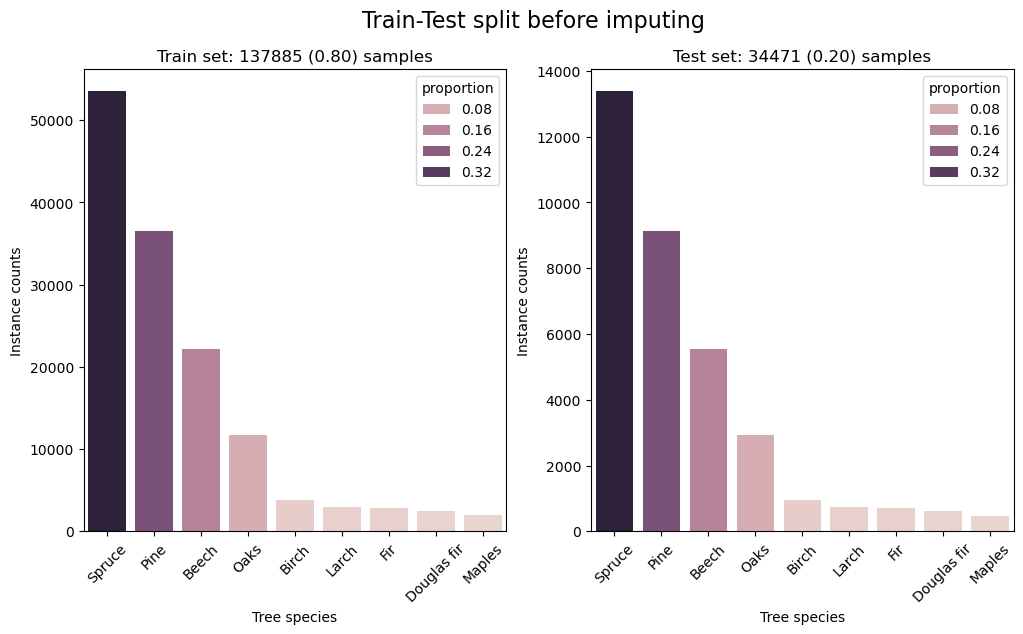

In [28]:
plot_train_test_split(data_cop_train['Ba'], data_cop_test['Ba'], 'Train-Test split before imputing')

In [29]:
# Drop all NaNs in the test set 
data_test = data_cop_test.dropna(how='any')
data_train_noimpute = data_cop_train.dropna(how='any')

if data_test.isna().sum().sum() != 0:
    print(f"There are still NaN values in the test set")

if data_train_noimpute.isna().sum().sum() != 0:
    print(f"There are still NaN values in the train set")

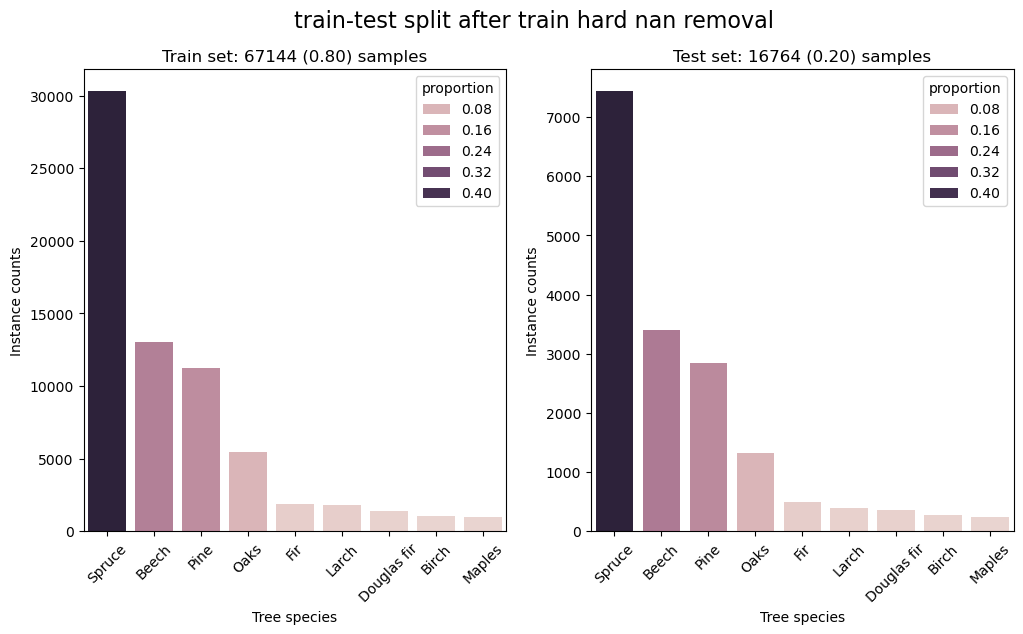

In [30]:
plot_train_test_split(data_train_noimpute['Ba'], data_test['Ba'], 'train-test split after train hard nan removal')

Write noimpute and testset to disk 

In [31]:
data_test.to_csv('../datasets/ml_bwi_v3_test.csv', index=False)
data_train_noimpute.to_csv('../datasets/ml_bwi_v3_train_noimpute.csv', index=False)

# Imputing 

In [32]:
data_cop_train_features = data_cop_train.drop(columns=['Tnr', 'Enr', 'Ba', 'bl'])

In [33]:
def print_nans_per_column(df):
    nans = df.isna().sum()
    nans = nans[nans > 0]
    print(nans)

In [34]:
print_nans_per_column(data_cop_train_features)

D7                1111
Biov_o             140
Gexp             51443
Gform                4
NatNaeheHaupt      103
Bkl               6181
BODTYP            6843
NAEHR            19343
WASSER           13047
nfk_30            9690
bio_6              248
bio_8               11
bio_9               38
bio_11             261
dtype: int64


In [35]:
categorical_columns = data_cop_train_features.select_dtypes(include='object').columns.tolist()
numerical_columns = data_cop_train_features.drop(columns=categorical_columns).columns.tolist()

In [36]:
data_cop_train_features['BODTYP'] = data_cop_train_features['BODTYP'].replace(np.nan, np.nan)

In [37]:
print_nans_per_column(data_cop_train_features)

D7                1111
Biov_o             140
Gexp             51443
Gform                4
NatNaeheHaupt      103
Bkl               6181
BODTYP            6843
NAEHR            19343
WASSER           13047
nfk_30            9690
bio_6              248
bio_8               11
bio_9               38
bio_11             261
dtype: int64


In [38]:
miss_indicator = MissingIndicator(missing_values=np.nan, features='all')
missing_mask_imputation = miss_indicator.fit_transform(data_cop_train_features)

In [39]:
np.save('../datasets/missing_mask_imputation.npy', missing_mask_imputation)

In [40]:
df_missing_mask = pd.DataFrame(missing_mask_imputation, columns=data_cop_train_features.columns)

In [41]:
df_missing_mask = df_missing_mask.replace({True: np.nan, False: 'not missing'})
print_nans_per_column(df_missing_mask)

D7                1111
Biov_o             140
Gexp             51443
Gform                4
NatNaeheHaupt      103
Bkl               6181
BODTYP            6843
NAEHR            19343
WASSER           13047
nfk_30            9690
bio_6              248
bio_8               11
bio_9               38
bio_11             261
dtype: int64


In [42]:
# Make nans again based on the missing mask 
data_cop_train_features = data_cop_train_features.where(~missing_mask_imputation, np.nan)

In [43]:
# Index the categorical columns usin LabelEncoder to save encodings for later reuse
from sklearn.preprocessing import LabelEncoder

indexers = {}
for col in categorical_columns:
    le = LabelEncoder()
    indexer = le.fit(data_cop_train_features[col])
    data_cop_train_features[col] = indexer.transform(data_cop_train_features[col])
    indexers[col] = indexer

In [44]:
# Make nans again based on the missing mask 
data_cop_train_features = data_cop_train_features.where(~missing_mask_imputation, np.nan)

In [45]:
data_cop_train_features['BODTYP'].unique()

array([ 1., 12.,  5.,  0., 13.,  8., nan,  6., 10., 16.,  3., 11.,  2.,
        7.,  4., 15.,  9., 14.])

In [46]:
# Impute missing numerical values with StandardScaler and kNNImputer 
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

In [47]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', 'passthrough', categorical_columns)
    ]
)

features_transformed = preprocessor.fit_transform(data_cop_train_features)

features_transformed = pd.DataFrame(features_transformed, columns=preprocessor.get_feature_names_out())


In [48]:
used_StandardScaler = preprocessor.named_transformers_['num']

In [49]:
import joblib 
joblib.dump(used_StandardScaler, './experiments/imputation_related/num_features_standardscaler.joblib')

['./experiments/imputation_related/num_features_standardscaler.joblib']

In [53]:
imputer = KNNImputer(missing_values=np.nan, n_neighbors=1, add_indicator=True)

In [54]:
imputed = imputer.fit_transform(features_transformed)

: 

In [56]:
df_features_imputed = pd.DataFrame(imputed, columns=imputer.get_feature_names_out())
df_features_imputed.to_csv('../datasets/features_imputed.csv')

In [57]:
df_features_missing_indicators = df_features_imputed.filter(like='missingindicator')
df_features_missing_indicators.to_csv('../datasets/features_missing_indicators.csv')

In [54]:
# load datasets here to reduce processing time after
df_features_imputed = pd.read_csv('../datasets/features_imputed.csv', index_col=0)

In [55]:
df_features_after_imputation = df_features_imputed.iloc[:, 0:47]
df_features_after_imputation.columns = [col.split('__')[1] for col in df_features_after_imputation.columns]


In [56]:
for col in categorical_columns: 
  df_features_after_imputation.loc[:, col] = df_features_after_imputation[col].astype(int)
  df_features_after_imputation.loc[:, col] = indexers[col].inverse_transform(df_features_after_imputation[col].astype(int))  

C:\Users\davha\AppData\Local\Temp\ipykernel_84788\1071729237.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['main stand' 'main stand' 'main stand' ... 'main stand' 'main stand'
 'main stand']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_features_after_imputation.loc[:, col] = indexers[col].inverse_transform(df_features_after_imputation[col].astype(int))
C:\Users\davha\AppData\Local\Temp\ipykernel_84788\1071729237.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['middle sloping site' 'middle sloping site' 'middle sloping site' ...
 'middle sloping site' 'middle sloping site' 'middle sloping site']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_features_after_imputation.loc[:, col] = indexers[col].inverse_transform(df_features_after_imputat

In [57]:
if df_features_after_imputation.isna().sum().sum() != 0:
    print(f"There are still NaN values in the set")

In [58]:
df_features_after_imputation.info()

<class 'pandas.core.frame.DataFrame'>
Index: 137885 entries, 0 to 137884
Data columns (total 47 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Al_ba          137885 non-null  float64
 1   Bhd            137885 non-null  float64
 2   Hoehe          137885 non-null  float64
 3   D7             137885 non-null  float64
 4   D03            137885 non-null  float64
 5   G              137885 non-null  float64
 6   VolR           137885 non-null  float64
 7   N_ha           137885 non-null  float64
 8   Stf            137885 non-null  float64
 9   Biom_o         137885 non-null  float64
 10  Biov_o         137885 non-null  float64
 11  Gexp           137885 non-null  float64
 12  Gneig          137885 non-null  float64
 13  HoeheNN        137885 non-null  float64
 14  TOT            137885 non-null  float64
 15  nfk_30         137885 non-null  float64
 16  bio_1          137885 non-null  float64
 17  bio_2          137885 non-null  fl

In [61]:
# redo scaling for numerical columns 
df_features_after_imputation[numerical_columns] = used_StandardScaler.inverse_transform(df_features_after_imputation[numerical_columns])

C:\Users\davha\AppData\Local\Temp\ipykernel_84788\3262291854.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features_after_imputation[numerical_columns] = used_StandardScaler.inverse_transform(df_features_after_imputation[numerical_columns])


In [66]:
data_train_imputed = pd.concat([data_cop_train[['Tnr', 'Enr', 'Ba', 'bl']].reset_index(drop=True), df_features_after_imputation.reset_index(drop=True)], axis=1)

In [ ]:
# Save imputed dataset
data_train_imputed.to_csv('../datasets/ml_bwi_v3_train_imputed.csv')

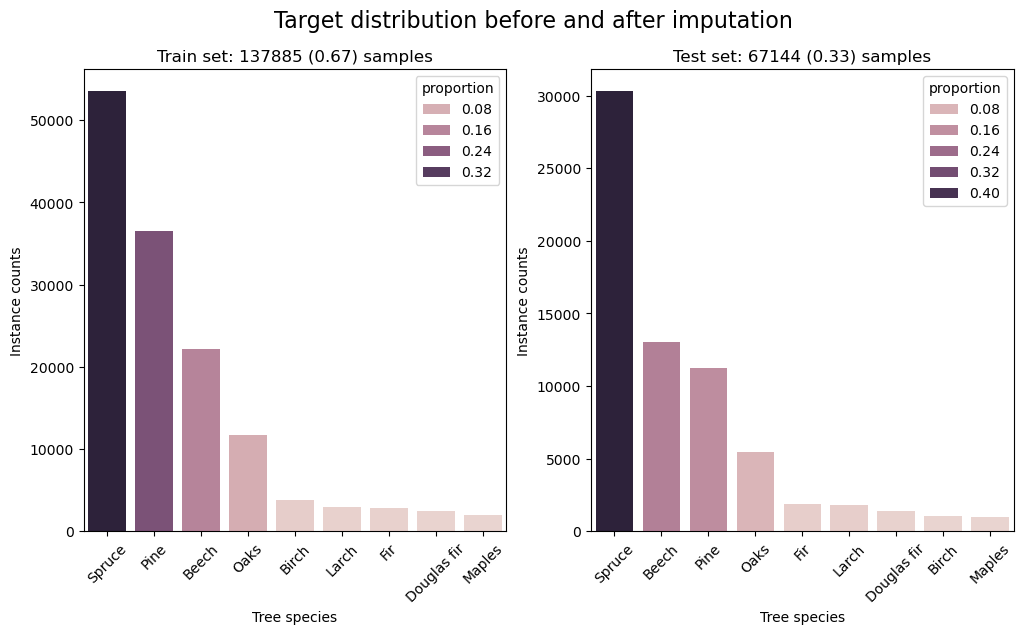

In [65]:
plot_train_test_split(data_train_imputed['Ba'], data_train_noimpute['Ba'], 'Target distribution before and after imputation')

In [68]:
# Filter rows where any of the missing indicator columns have a value of 1
missing_instances = df_features_missing_indicators[(df_features_missing_indicators == 1).any(axis=1)]
missing_instances

,missingindicator_num__D7,missingindicator_num__Biov_o,missingindicator_num__Gexp,missingindicator_num__nfk_30,missingindicator_num__bio_6,missingindicator_num__bio_8,missingindicator_num__bio_9,missingindicator_num__bio_11,missingindicator_cat__Gform,missingindicator_cat__NatNaeheHaupt,missingindicator_cat__Bkl,missingindicator_cat__BODTYP,missingindicator_cat__NAEHR,missingindicator_cat__WASSER
35,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
41,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137850,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
137851,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
137852,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
137853,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
